In [ ]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from tslearn.metrics import dtw, soft_dtw
from tslearn.utils import to_time_series_dataset
from sklearn.utils.validation import _check_large_sparse
from tslearn.clustering import TimeSeriesKMeans
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.metrics import pairwise_distances_argmin_min, jaccard_score, f1_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

In [ ]:
def boolean_df(item_lists, unique_items):
# Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask
        bool_dict[item] = item_lists.apply(lambda x: 1 if item in x else 0)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

In [ ]:
emoji_map = {'neutral': ['none'], 'smirk':['contempt'], 'furious':['furious'], 'weary':['annoyed'], 'expressionless':['annoyed'], 'unamused': ['contempt'], 'rollingeyes':['annoyed'], 'none':['none'], 'angry':['anger'], 'triumph':['hatred'], 'hatred':['hatred']} 
# na_emoji_map = {'neutral': ['none'], 'smirk':['contempt'], 'furious':['furious', 'anger'], 'weary':['disgust'], 'expressionless':['contempt','annoyed'], 'unamused': ['annoyed', 'contempt'], 'rollingeyes':['annoyed'], 'none':['none'], 'skeptical':['none'], 'angry':['anger', 'annoyed'], 'nauseated':['disgust'], 'vomiting':['disgust'], 'triumph':['anger'], 'hatred':['hatred', 'furious']}

In [ ]:
# Reading NA data
X_df_na = pd.read_csv('../new_data/NA/na_dataset.csv', index_col=None)
Y_df_na = pd.read_csv('../new_data/NA/na_emoji_labels_cleaned.csv', usecols=['filename', 'emoji'], index_col='filename')
emotion_df_na = pd.read_csv('../new_data/NA/na_labels_cleaned.csv', usecols=['filename', 'emotions'], index_col='filename')
# Reading Persian data
X_df_p = pd.read_csv('../new_data/Persian/persian_dataset.csv', index_col=None)
Y_df_p = pd.read_csv('../new_data/Persian/p_emoji_labels_cleaned.csv', usecols=['filename', 'emoji'], index_col='filename')
emotion_df_p = pd.read_csv('../new_data/Persian/p_labels_cleaned.csv', usecols=['filename', 'emotions'], index_col='filename')

# concatenate them
Y_df = pd.concat([Y_df_na, Y_df_p], sort=False)
X_df = pd.concat([X_df_na, X_df_p], ignore_index=True, sort=False)
emotion_df = pd.concat([emotion_df_na, emotion_df_p], sort=False)


In [59]:
X_df = X_df[X_df['filename'].isin(Y_df.index)]
X_df.reset_index(inplace=True, drop=True)
Y_df["emoji"] = Y_df["emoji"].apply(eval)
emotion_df["emotions"] = emotion_df["emotions"].apply(eval)
label_cols = to_1D(Y_df["emoji"]).unique() 
emotion_cols = to_1D(emotion_df["emotions"]).unique() 
# label_cols.append('smilingimp')
labels_expanded = boolean_df(Y_df['emoji'], label_cols )
emotions_expanded = boolean_df(emotion_df['emotions'], emotion_cols )


In [ ]:
len(X_df['filename'].unique())
# len(Y_df.index.unique())

In [ ]:
labels_expanded.loc['persian/vid_5.mp4']

In [ ]:
for l in label_cols:
    X_df[label_cols]  = np.NaN
    

In [ ]:
X_df.head()

In [ ]:
label_cols.tolist()

In [ ]:
print(labels_expanded.at['persian/vid_97.mp4', 'furious'])

In [60]:
for index, row in X_df.iterrows():
    # print(index, row)
    try:
        filename = X_df.iloc[index]['filename']
    except Exception:
        print("index: ", index)
        print('expanded labels: filename: {}, label: {}, {}'.format(filename, l, labels_expanded.at[filename, l]))
        # print(X_df.at[index, l])
    # print(filename)
    for l in label_cols.tolist():
        
    # print(labels_expanded.loc[filename]['none':'hatred'].to_list())
        X_df.at[index, l] = labels_expanded.at[filename, l]
        
        

In [61]:
for index, row in X_df.iterrows():
    # print(index, row)
    filename = X_df.iloc[index]['filename']
    # print(filename)
    for l in emotion_cols.tolist():
        try:
    # print(labels_expanded.loc[filename]['none':'hatred'].to_list())
            X_df.at[index, l] = emotions_expanded.at[filename, l]
        except Exception:
            # print("here")
            print('expanded labels: filename: {}, label: {}, {}'.format(filename, l, emotions_expanded.at[filename, l]))
            print(X_df.at[index, l])

In [ ]:
X_df

### Min-Max Scaling

In [ ]:
## Ablation cols
ablation_cols = ['AU01_r','AU02_r','AU04_r','AU05_r','AU06_r','AU07_r','AU09_r', 'AU10_r','AU12_r','AU14_r','AU15_r','AU17_r','AU20_r','AU23_r','AU25_r','AU26_r','AU45_r']

In [ ]:
X_df = X_df.drop(columns=ablation_cols)
X_df

In [62]:
cols_to_scale = list (
    set(X_df.columns.to_list()) - set(['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success'])- set(label_cols)-set(emotion_cols)
    )
scaler = MinMaxScaler()
X_df[cols_to_scale] = scaler.fit_transform(X_df[cols_to_scale])

In [ ]:
X_df.tail()

## Splitting into train and test

In [ ]:
['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success'] + label_cols.tolist()

In [63]:
metadata_cols = ['frame', 'face_id', 'culture', 'filename', 'timestamp']
cols_to_drop = ['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success'] + label_cols.tolist() + emotion_cols.tolist()

videos = X_df['filename'].unique()
# test_videos = pd.Series(videos).sample(frac=0.35)
test_videos = ['na/vid_13.mp4', 'na/vid_92.mp4', 'na/vid_93.mp4', 'na/vid_6.mp4', 'na/vid_14.mp4', 'na/vid_10_1.mp4', 'na/vid_34.mp4', 'na/vid_86.mp4', 'na/vid_83.mp4', 'na/vid_90.mp4', 'na/vid_60.mp4', 'na/vid_24.mp4', 'na/vid_10_3.mp4', 'na/vid_10_2.mp4', 'na/vid_87.mp4', 'na/vid_32.mp4', 'na/vid_79.mp4', 'na/vid_68.mp4', 'na/vid_56.mp4', 'na/vid_36.mp4']
test_videos.extend(['persian/vid_59.mp4', 'persian/vid_79.mp4', 'persian/vid_40.mp4', 'persian/vid_10.mp4', 'persian/vid_1.mp4', 'persian/vid_5.mp4', 'persian/vid_44.mp4', 'persian/vid_85.mp4', 'persian/vid_25.mp4', 'persian/vid_75.mp4', 'persian/vid_66.mp4', 'persian/vid_50.mp4', 'persian/vid_81.mp4', 'persian/vid_60.mp4', 'persian/vid_87.mp4', 'persian/vid_90.mp4', 'persian/vid_35.mp4', 'persian/vid_37.mp4', 'persian/vid_42.mp4', 'persian/vid_69.mp4', 'persian/vid_70.mp4', 'persian/vid_52.mp4', 'persian/vid_53.mp4', 'persian/vid_82.mp4'])

# test_videos = pd.Series(videos).sample(frac=0.25)
train_videos = np.array(list(set(videos) - set(test_videos)))
test_df = X_df[X_df['filename'].isin(test_videos)]
metadata_test = test_df[metadata_cols]
metadata_test.reset_index(inplace=True)
y_test = test_df[label_cols].values
y_test_emotions = test_df[emotion_cols]
X_test = test_df.drop(columns = cols_to_drop).values
print(X_test.shape)
test_df

(4122, 22)


,filename,culture,frame,face_id,timestamp,confidence,success,AU01_r,AU02_r,AU04_r,...,expressionless,unamused,rollingeyes,none,angry,triumph,hatred,anger,annoyed,contempt
149,na/vid_10_1.mp4,north american,1,0,0.000,0.98,1,0.157333,0.614,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
150,na/vid_10_1.mp4,north american,2,0,0.033,0.98,1,0.170667,0.602,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
151,na/vid_10_1.mp4,north american,3,0,0.067,0.98,1,0.109333,0.568,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
152,na/vid_10_1.mp4,north american,4,0,0.100,0.98,1,0.090667,0.594,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
153,na/vid_10_1.mp4,north american,5,0,0.133,0.98,1,0.186667,0.642,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14038,persian/vid_90.mp4,persian,36,0,1.400,0.98,1,0.674667,0.466,0.129754,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
14039,persian/vid_90.mp4,persian,37,0,1.440,0.98,1,0.704000,0.458,0.118568,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
14040,persian/vid_90.mp4,persian,38,0,1.480,0.98,1,0.725333,0.470,0.131991,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
14041,persian/vid_90.mp4,persian,39,0,1.520,0.98,1,0.714667,0.446,0.140940,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


In [64]:
print(len(test_videos))

44


## Cross-validation

In [65]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

kfold = KFold(5, True, 1)
frames_mean_hm_test = []
frames_mean_jac_test = []
videos_mean_jac_test = []
videos_mean_hm_test = []
# metadata_test.reset_index(inplace=True)

col_indices = {i:label for (i,label) in enumerate(label_cols)}

splits = kfold.split(train_videos)
for (i, (train, test)) in enumerate(splits):
    # print(videos[train])
    # print(videos[test])
    print('%d-th split: train: %d, test: %d' % (i+1, len(train_videos[train]), len(train_videos[test])))
    train_df = X_df[X_df['filename'].isin(train_videos[train])]
    print(train_videos[train])
    train_metadata = train_df[metadata_cols]
    print('Training+validation data size: ', train_df.shape[0])
    y_train = train_df[label_cols].values
    X_train = train_df.drop(columns = cols_to_drop).values
    valid_df = X_df[X_df['filename'].isin(train_videos[test])]
    y_valid = valid_df[label_cols].values
    X_valid = valid_df.drop(columns = cols_to_drop).values
    # X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    print('Training data size: ', X_train.shape[0])
    print('Validation data size: ', X_valid.shape[0])
    base_knn =  KNeighborsClassifier(n_neighbors=5,)
    base_lr = LogisticRegression()
    base_rf = RandomForestClassifier()
    base_xgb = XGBClassifier(objective="binary:logistic", eval_metric='logloss')

    multiclass_xg = MultiOutputClassifier(XGBClassifier(objective='binary:logistic', eval_metric='logloss'))
    # ovr = LogisticRegression()
    multiclass_xg.fit(X_train, y_train)
    valid_pred_xgb = multiclass_xg.predict(X_valid)
    ovr_jaccard_score = jaccard_score(y_valid, valid_pred_xgb, average='samples') # TODO
    ovr_ham_loss = metrics.hamming_loss(y_valid, valid_pred_xgb)
    print("XGB-multi validation Jaccard score:" , ovr_jaccard_score)
    print("XGB-multi validation Hamming loss: " , ovr_ham_loss)

    Y_pred_ovr = multiclass_xg.predict(X_test)
    a = jaccard_score(y_test, Y_pred_ovr, average='samples') #TODO
    b = metrics.hamming_loss(y_test, Y_pred_ovr)
    # print(Y_pred_ovr[800:805,:])
    # print(y_test[800:805,:])

    print("XGB-multi test Jaccard score: ", a)
    print("XGB-multi test Hamming loss: " , b)
    chains = [ClassifierChain(base_xgb, order='random', random_state=i) for i in range(14)]
    best_model_index = 0
    best_jac = 0
    for j, model in enumerate(chains):
        model.fit(X_train, y_train)
        valid_pred = model.predict(X_valid)
        val_score =jaccard_score(y_valid, valid_pred, average='samples')
        if val_score > best_jac:
            best_model_index = j
            best_jac = val_score
        
        
    # predict on validation data
    valid_pred_chains = chains[best_model_index].predict(X_valid)
    chain_jaccard_scores = jaccard_score(y_valid, valid_pred_chains >= .5,
                                    average='samples')
                    
    
    print("CC Validation Jaccard Score:\n ", chain_jaccard_scores)

    chain_hamming_loss = metrics.hamming_loss(y_valid, valid_pred_chains >= .5)
                
    print("CC Validation Hamming Loss:\n ", chain_hamming_loss)

    # test on test data
    Y_pred_chains = chains[best_model_index].predict(X_test)
    chain_jaccard_scores = jaccard_score(y_test, Y_pred_chains >= .5,
                                    average='samples')
                    
    frames_mean_jac_test.append(np.mean(chain_jaccard_scores))
    print("CC Test Jaccard Score: \n ", chain_jaccard_scores)

    chain_hamming_loss = metrics.hamming_loss(y_test, Y_pred_chains) 
               
    frames_mean_hm_test.append(chain_hamming_loss)
    print("CC Test Hamming Loss:\n ", chain_hamming_loss)
    ## voting predicted labels
    # test_result_df = pd.DataFrame(columns=metadata_cols, data=metadata_test.values)
    # test_result_df.update(metadata_test)
    temp_df = pd.DataFrame(data=Y_pred_chains, columns=label_cols)

    # TODO: map emojis to emotions using temp_df
    test_result_df = None
    test_result_df = pd.concat([metadata_test, temp_df], axis=1)
    print("Test result df shape = ", test_result_df.shape)
    emoji_video_groups = test_result_df.groupby('filename')[label_cols].sum()
   

    ground_truth_video_labels = []
    
    for v in emoji_video_groups.index.to_list():
        # number of 1s in ground truth labels
        ground_truth_video_labels.append(test_df[test_df['filename'] == v].iloc[0][label_cols])
        
        num_1s = test_df[test_df['filename'] == v].iloc[0][label_cols].sum()
        num_1s = int(num_1s)
        a = np.argsort(emoji_video_groups.loc[v].values)
        for i in range(len(a) - 1, len(a) - num_1s - 1, -1):
            emoji_video_groups.loc[v][a[i]] = 1
        for i in range(0, len(a) - num_1s):
            emoji_video_groups.loc[v][a[i]] = 0
        
    
    print(np.array(ground_truth_video_labels,  dtype=int).shape)
    print(emoji_video_groups.values.shape)

    j = metrics.jaccard_score(np.array(ground_truth_video_labels,  dtype=int), emoji_video_groups.values, average='samples')
    h = metrics.hamming_loss(np.array(ground_truth_video_labels,  dtype=int), emoji_video_groups.values)
    videos_mean_jac_test.append(j)
    videos_mean_hm_test.append(h)

1-th split: train: 98, test: 25
['na/vid_37.mp4' 'persian/vid_19.mp4' 'na/vid_7.mp4' 'persian/vid_72.mp4'
 'persian/vid_46.mp4' 'persian/vid_15.mp4' 'persian/vid_33.mp4'
 'na/vid_18.mp4' 'persian/vid_97.mp4' 'na/vid_17.mp4' 'persian/vid_28.mp4'
 'na/vid_67.mp4' 'na/vid_100.mp4' 'na/vid_73.mp4' 'persian/vid_58.mp4'
 'persian/vid_93.mp4' 'persian/vid_62.mp4' 'persian/vid_83.mp4'
 'persian/vid_94.mp4' 'na/vid_5.mp4' 'persian/vid_22.mp4' 'na/vid_25.mp4'
 'persian/vid_32.mp4' 'na/vid_85.mp4' 'persian/vid_12.mp4'
 'persian/vid_55.mp4' 'na/vid_88.mp4' 'persian/vid_14.mp4'
 'persian/vid_4.mp4' 'na/vid_35.mp4' 'na/vid_72.mp4' 'na/vid_97.mp4'
 'na/vid_76.mp4' 'na/vid_21.mp4' 'na/vid_38.mp4' 'persian/vid_67.mp4'
 'persian/vid_95.mp4' 'na/vid_19.mp4' 'na/vid_22.mp4' 'na/vid_3.mp4'
 'persian/vid_71.mp4' 'na/vid_63.mp4' 'persian/vid_57.mp4' 'na/vid_11.mp4'
 'na/vid_81.mp4' 'persian/vid_8.mp4' 'persian/vid_63.mp4'
 'persian/vid_3.mp4' 'na/vid_62.mp4' 'persian/vid_65.mp4'
 'persian/vid_20.mp4' 'persia

In [ ]:
print(test_result_df.shape)
print(temp_df.shape)
print(metadata_test.shape)
print(emoji_video_groups.shape)
len(test_videos)

In [ ]:
emotion_mapped_df.sum()

In [66]:
emotion_mapped_df = pd.DataFrame(columns=emotion_cols.tolist(), data=np.zeros((temp_df.shape[0], len(emotion_cols)), dtype=int))
emotion_mapped_df['filename'] = test_result_df['filename']
for emoji in label_cols.tolist():
    indices = temp_df[temp_df[emoji]==1].index
    emotions = emoji_map[emoji] # TODO: change to persian_emoji_map for persian
    # print(indices)
    # print(emotion)
    for emotion in emotions:
        emotion_mapped_df.at[indices.to_list(), emotion] = 1
emotion_video_groups = emotion_mapped_df.groupby('filename')[emotion_cols].sum()
ground_truth_video_emotions = []
for v in emotion_video_groups.index.to_list():
    ground_truth_video_emotions.append(test_df[test_df['filename'] == v].iloc[0][emotion_cols])
    num_1s = test_df[test_df['filename'] == v].iloc[0][emotion_cols].sum()
    num_1s = int(num_1s)
    a = np.argsort(emotion_video_groups.loc[v].values)
    for i in range(len(a) - 1, len(a) - num_1s - 1, -1):
        emotion_video_groups.loc[v][a[i]] = 1
    for i in range(0, len(a) - num_1s):
        emotion_video_groups.loc[v][a[i]] = 0


In [ ]:
emotion_mapped_df.head()

# Categorizing emoji results into emotions

In [67]:

print('------------------- Frame-level F1 -----------------')
print(metrics.classification_report(emotion_mapped_df.drop('filename', axis=1).values,  y_test_emotions.values, target_names=emotion_cols))
print('------------------- Video-level F1 -----------------')
print(metrics.classification_report(np.array(ground_truth_video_emotions,  dtype=int),  emotion_video_groups.values, target_names=emotion_cols))

------------------- Frame-level F1 -----------------
              precision    recall  f1-score   support

        none       0.05      0.06      0.06       206
     furious       0.36      0.69      0.47       686
       anger       0.21      0.33      0.26      1190
     annoyed       0.30      0.72      0.43       609
    contempt       0.34      0.09      0.14      1435
      hatred       0.03      0.07      0.04       384

   micro avg       0.24      0.33      0.28      4510
   macro avg       0.22      0.33      0.23      4510
weighted avg       0.26      0.33      0.25      4510
 samples avg       0.25      0.31      0.26      4510

------------------- Video-level F1 -----------------
              precision    recall  f1-score   support

        none       0.50      0.20      0.29         5
     furious       0.50      0.30      0.37        10
       anger       0.29      0.22      0.25        18
     annoyed       0.33      0.18      0.24        11
    contempt       0.13   

In [ ]:
print('------------------- Frame-level Jaccard -----------------')
print(metrics.jaccard_score(emotion_mapped_df.drop('filename', axis=1).values,  y_test_emotions.values, average='samples'))
print('------------------- Video-level Jaccard -----------------')
print(metrics.jaccard_score(np.array(ground_truth_video_emotions,  dtype=int),  emotion_video_groups.values, average='samples'))

In [69]:
print('----------------- Frame-level F1 (emoji) ----------------')
print(metrics.classification_report(y_test,  Y_pred_chains, target_names=label_cols.tolist()))

print('----------------- Video-level F1 (emoji) ----------------')
print(metrics.classification_report(np.array(ground_truth_video_labels,  dtype=int), emoji_video_groups.values, target_names=label_cols.tolist()))

----------------- Frame-level F1 (emoji) ----------------
                precision    recall  f1-score   support

       neutral       0.00      0.00      0.00       111
         smirk       0.05      0.08      0.06       132
       furious       0.69      0.36      0.47      1319
         weary       0.80      0.21      0.34       363
expressionless       0.33      0.21      0.25       537
      unamused       0.30      0.41      0.35       876
   rollingeyes       0.21      0.06      0.10       706
          none       0.00      0.00      0.00       222
         angry       0.36      0.26      0.30      1637
       triumph       0.07      0.09      0.08       260
        hatred       0.81      0.02      0.04       871

     micro avg       0.34      0.22      0.27      7034
     macro avg       0.33      0.15      0.18      7034
  weighted avg       0.44      0.22      0.26      7034
   samples avg       0.31      0.22      0.24      7034

----------------- Video-level F1 (emoji) --

In [71]:
print('------------------- Frame-level Jaccard (emojis) -----------------')
print(metrics.jaccard_score(y_test,  Y_pred_chains, average='samples'))

print('------------------- Video-level Jaccard (emojis) -----------------')
print(metrics.jaccard_score(np.array(ground_truth_video_labels,  dtype=int),  emoji_video_groups.values, average='samples'))

------------------- Frame-level Jaccard (emojis) -----------------
0.1937328157852175
------------------- Video-level Jaccard (emojis) -----------------
0.23477297895902546


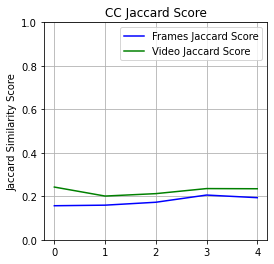

In [72]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('CC Jaccard Score')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Jaccard Similarity Score')
ax.set_ylim([0.00, 1.0])

plt.plot(frames_mean_jac_test, label='Frames Jaccard Score', color='blue')
plt.plot(videos_mean_jac_test, label='Video Jaccard Score', color='green')
plt.legend(loc='best')
plt.show()

In [ ]:
videos_mean_jac_test

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('CC Hamming Loss')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Hamming Distance Loss')
ax.set_ylim([0.00, 1.0])
# ax.legend(('Frames Hamming Loss','Video Hamming Loss' ))
plt.plot(frames_mean_hm_test, label='Frames Hamming Loss', color='red')
plt.plot(videos_mean_hm_test, label='Video Hamming Loss', color='green')
plt.legend(loc='upper right')
plt.show()

In [73]:
from skmultilearn.adapt import MLkNN
import sklearn.metrics as metrics

## MLTSVM is not compatible with later versions of numpy

kfold = KFold(5, True, 1)
frames_mean_hm_test = []
frames_mean_jac_test = []
videos_mean_jac_test = []
videos_mean_hm_test = []
col_indices = {i:label for (i,label) in enumerate(label_cols)}

splits = kfold.split(train_videos)
for (i, (train, test)) in enumerate(splits):
    print('%d-th split: train: %d, validation: %d' % (i+1, len(videos[train]), len(videos[test])))
    train_df = X_df[X_df['filename'].isin(train_videos[train])]
    train_metadata = train_df[metadata_cols]
    print('Training+validation data size: ', train_df.shape[0])
    y_train = train_df[label_cols].values
    X_train = train_df.drop(columns = cols_to_drop).values
    valid_df = X_df[X_df['filename'].isin(train_videos[test])]
    y_valid = valid_df[label_cols].values
    X_valid = valid_df.drop(columns = cols_to_drop).values
    
    print('Training data size: ', X_train.shape[0])
    print('Validation data size: ', X_valid.shape[0])
    classifier = MLkNN(k=5)
    # classifier = MLTSVM(c_k = 2**-1)
    prediction = classifier.fit(X_train, y_train).predict(X_valid)

    # Predicting on validation set
    print("Validation Hamming Loss:\n ", metrics.hamming_loss(y_valid, prediction))

    # Predicting on test set
    y_test_pred = classifier.predict(X_test)
    hm_loss = metrics.hamming_loss(y_test, y_test_pred)
    frames_mean_hm_test.append(hm_loss)
    print("Test Hamming Loss:\n ", hm_loss)
    jac_score = jaccard_score(y_test, y_test_pred,  average='samples')
    frames_mean_jac_test.append(jac_score)
    print("Test Jaccard Score:\n ", jac_score)

    # building test dataframe to vote labels
    test_result_df = None
    
    temp_df = pd.DataFrame(data=y_test_pred.toarray(), columns=label_cols)
    test_result_df = pd.concat([metadata_test, temp_df], axis=1)
    
    # print(test_result_df.head())
    video_groups = test_result_df.groupby('filename')[label_cols].apply(lambda x : x.astype(int).sum())
    # for name, group in video_groups:
    #     print(name)
    #     print(group)
    #     print("\n") 
    ground_truth_video_labels = []
    for v in video_groups.index.to_list():
        # number of 1s in ground truth labels
        ground_truth_video_labels.append(test_df[test_df['filename'] == v].iloc[0][label_cols])
        num_1s = test_df[test_df['filename'] == v].iloc[0][label_cols].sum()
        num_1s = int(num_1s)
        a = np.argsort(video_groups.loc[v].values)
        for i in range(len(a) - 1, len(a) - num_1s - 1, -1):
            video_groups.loc[v][a[i]] = 1
        for i in range(0, len(a) - num_1s):
            video_groups.loc[v][a[i]] = 0

    j = metrics.jaccard_score(np.array(ground_truth_video_labels,  dtype=int), video_groups.values, average='samples')
    h = metrics.hamming_loss(np.array(ground_truth_video_labels,  dtype=int), video_groups.values)
    videos_mean_jac_test.append(j)
    videos_mean_hm_test.append(h)
        

1-th split: train: 98, validation: 25
Training+validation data size:  8123
Training data size:  8123
Validation data size:  2535
Validation Hamming Loss:
  0.21100950331719562
Test Hamming Loss:
  0.21598076838251512
Test Jaccard Score:
  0.18264365425937476
2-th split: train: 98, validation: 25
Training+validation data size:  8810
Training data size:  8810
Validation data size:  1848
Validation Hamming Loss:
  0.24173553719008264
Test Hamming Loss:
  0.2227515327952009
Test Jaccard Score:
  0.1641528615327742
3-th split: train: 98, validation: 25
Training+validation data size:  8146
Training data size:  8146
Validation data size:  2512
Validation Hamming Loss:
  0.24413723219455705
Test Hamming Loss:
  0.2145251643068237
Test Jaccard Score:
  0.16680702848825119
4-th split: train: 99, validation: 24
Training+validation data size:  8447
Training data size:  8447
Validation data size:  2211
Validation Hamming Loss:
  0.23230952674643313
Test Hamming Loss:
  0.20806316439504213
Test Jacc

In [ ]:
y_test_pred.shape

In [74]:
emotion_mapped_df = None
emotion_mapped_df = pd.DataFrame(columns=emotion_cols.tolist(), data=np.zeros((temp_df.shape[0], len(emotion_cols)), dtype=int))
emotion_mapped_df['filename'] = test_result_df['filename']
for emoji in label_cols.tolist():
    indices = temp_df[temp_df[emoji]==1].index
    emotions = emoji_map[emoji] # TODO: change to persian_emoji_map for persian
    # print(indices)
    # print(emotion)
    for emotion in emotions:
        emotion_mapped_df.at[indices.to_list(), emotion] = 1
emotion_video_groups = emotion_mapped_df.groupby('filename')[emotion_cols].sum()
ground_truth_video_emotions = []
for v in emotion_video_groups.index.to_list():
    ground_truth_video_emotions.append(test_df[test_df['filename'] == v].iloc[0][emotion_cols])
    num_1s = test_df[test_df['filename'] == v].iloc[0][emotion_cols].sum()
    num_1s = int(num_1s)
    a = np.argsort(emotion_video_groups.loc[v].values)
    for i in range(len(a) - 1, len(a) - num_1s - 1, -1):
        emotion_video_groups.loc[v][a[i]] = 1
    for i in range(0, len(a) - num_1s):
        emotion_video_groups.loc[v][a[i]] = 0


## MLKNN - Categorizing emotions into emojis

In [75]:
print('------------------- Frame-level F1 -----------------')
print(metrics.classification_report(emotion_mapped_df.drop('filename', axis=1).values,  y_test_emotions.values, target_names=emotion_cols))
print('------------------- Video-level F1 -----------------')
print(metrics.classification_report(np.array(ground_truth_video_emotions,  dtype=int),  emotion_video_groups.values, target_names=emotion_cols))

------------------- Frame-level F1 -----------------
              precision    recall  f1-score   support

        none       0.22      0.11      0.14       455
     furious       0.51      0.57      0.54      1185
       anger       0.21      0.43      0.28       898
     annoyed       0.41      0.55      0.47      1061
    contempt       0.35      0.09      0.14      1520
      hatred       0.13      0.19      0.15       585

   micro avg       0.32      0.34      0.33      5704
   macro avg       0.30      0.32      0.29      5704
weighted avg       0.34      0.34      0.31      5704
 samples avg       0.33      0.34      0.30      5704

------------------- Video-level F1 -----------------
              precision    recall  f1-score   support

        none       0.40      0.40      0.40         5
     furious       0.33      0.40      0.36        10
       anger       0.75      0.33      0.46        18
     annoyed       0.71      0.45      0.56        11
    contempt       0.17   

In [76]:
print('------------------- Frame-level Jaccard -----------------')
print(metrics.jaccard_score(emotion_mapped_df.drop('filename', axis=1).values,  y_test_emotions.values, average='samples'))
print('------------------- Video-level Jaccard -----------------')
print(metrics.jaccard_score(np.array(ground_truth_video_emotions,  dtype=int),  emotion_video_groups.values, average='samples'))

------------------- Frame-level Jaccard -----------------
0.25475901665858003
------------------- Video-level Jaccard -----------------
0.34108527131782945


In [77]:
print('------------------- Frame-level F1 (emoji) -----------------')
print(metrics.classification_report(y_test,  y_test_pred, target_names=label_cols.tolist()))

print('------------------- Video-level F1 (emoji) -----------------')
print(metrics.classification_report(np.array(ground_truth_video_labels,  dtype=int),  video_groups.values, target_names=label_cols.tolist()))

------------------- Frame-level F1 (emoji) -----------------
                precision    recall  f1-score   support

       neutral       0.09      0.20      0.12       111
         smirk       0.03      0.06      0.04       132
       furious       0.57      0.51      0.54      1319
         weary       0.30      0.20      0.24       363
expressionless       0.33      0.28      0.30       537
      unamused       0.25      0.39      0.30       876
   rollingeyes       0.30      0.23      0.26       706
          none       0.02      0.03      0.03       222
         angry       0.40      0.22      0.28      1637
       triumph       0.11      0.20      0.14       260
        hatred       0.32      0.03      0.06       871

     micro avg       0.31      0.27      0.29      7034
     macro avg       0.25      0.21      0.21      7034
  weighted avg       0.35      0.27      0.28      7034
   samples avg       0.31      0.25      0.25      7034

------------------- Video-level F1 (emoj

In [ ]:
print('------------------- Frame-level Jaccard (emoji) -----------------')
print(metrics.jaccard_score(y_test,  y_test_pred, average='samples'))

print('------------------- Video-level Jaccard (emoji) -----------------')
print(metrics.jaccard_score(np.array(ground_truth_video_labels,  dtype=int),  video_groups.values, average='samples'))

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('MLKNN Jaccard Score')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Jaccard Similarity Score')
ax.set_ylim([0.0, 1.0])

plt.plot(frames_mean_jac_test, label='Frames Jaccard Score', color='blue')
plt.plot(videos_mean_jac_test, label='Video Jaccard Score', color='green')
plt.legend(loc='best')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('MLKNN Hamming Loss')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Hamming Distance Loss')
ax.set_ylim([0.00, 1.])# ax.legend(('Frames Hamming Loss','Video Hamming Loss' ))
plt.plot(frames_mean_hm_test, label='Frames Hamming Loss', color='red')
plt.plot(videos_mean_hm_test, label='Video Hamming Loss', color='green')
plt.legend(loc='upper right')
plt.show()

In [ ]:
print(y_test[800:805])
print(metadata_test[800:805])

In [ ]:
print(len(y_test))
print(len(metadata_test))

In [ ]:
def clean(input: str):
    input = 'persian/' + input +".mp4"
    return input
X_df = pd.read_csv('../new_data/Persian/persian_dataset.csv', index_col=None)
X_df['filename'] = X_df['filename'].apply(clean)
X_df.to_csv('../new_data/Persian/persian_dataset.csv', index=False)